### Business Goal:  Reducing the number of frustrated students who left the free trial because they didn't have enough time—without significantly reducing the number of students to continue past the free trial and eventually complete the course


### 1. Metrics Design


1. Gross Conversion (short-term): This metric tracks the percentage of users who choose to enter their credit card information and begin the free trial after clicking the "Start Free Trial" button. Since the change sets clearer expectations upfront, more students are likely to settle for the free material, recognizing when the course may not meet their needs. This metric allows us to quantify the immediate impact of the change and assess user behavior more accurately.
2. Retention (long-term): This metric tracks the percentage of users remain in the course and make their first payment after the free trial expires. The clearer expectations upfront should lead to a reduction of the number of furstrated students who left the free trial because they didn't have enough time. This metrics allows us to quantify the long-term impact of the change and assess user behavior more accurately.
3.  Guardrail metrics - Net Conversion: This metric tracks the percentage of users remain in the course and make their first payment, compared to the total users who clicked "Start Free Trial" button. It provides on overview of the entire funnel impact and checks if the conversion rate of users who become paying customers is negatively impacted. If net conversion drops, it could indicate that while users are willing to engage with the free trial, they are not converting into paying customers. We have to be cautious in launching a change if it has a negative effect on net conversion, as it would essentially decrease revenue

### 2. Sample Size Calculation 

Given the baseline statistics: 
- Gross Conversion: 0.20625
- Retention: 0.53
- Net Conversion: 0.1093125

In [63]:
import numpy as np
import statsmodels.api as sm

baseline = {
    "Gross_Conversion": {"p2": 0.20625, "d_min": 0.01},
    "Retention": {"p2":0.53, "d_min": 0.01},
    "Net_Conversion": {"p2":0.1093125, "d_min":0.0075}
}
# baseline proportion is named p2, treatment proportion is named p1 in statsmodels and other commonly used libraries for statistics
power = 0.8
alpha = 0.05


def direct_sample_calulate (p2, delta):
    sigma = np.sqrt(p2*(1-p2))
    n = 16 * sigma**2 / delta**2
    return n

def statsmodels_porportion_sample_calculate (dif,p2, power,alpha ):
    return  sm.stats.samplesize_proportions_2indep_onetail(diff=dif, prop2=p2, power=power, alpha=alpha)
    # parameters:
        # diff: min detectable difference
        # p2: baseline proportion
    # Since our focus is detecting increases in gross conversion, retention, and net conversion, one-tailed test would be more appropriate. 
    # In the case where variables for proportion calculations are all independent, we should use the 2indep version of the sample size method. 
    # Refer to dependent(paired) proportions if one of the variables in the proportions is dependent on the other

def statsmodels_effect_size_sample_calculation(p2, p1, power, alpha):
    effect_size = sm.stats.proportion_effectsize(p2, p1)
    return sm.stats.tt_ind_solve_power(effect_size=effect_size, power=power, alpha=alpha)
    # First converting the difference between the two proportions into a standardized effect size (Cohen’s h), then using that effect size 
    # to calculate the sample size with a power analysis function.

# ------------------- non-propotion sample size calculation ------------------ #
def continuous_effect_size_sample_calculation(mean_c, mean_t, std_c, std_t, power, alpha):
    pooled_std = np.sqrt((std_c ** 2 + std_t ** 2) / 2) # Calculate pooled standard deviation
    effect_size = (mean_t - mean_c) / pooled_std # Calculate Cohen's d (effect size for the difference in means)   
    return sm.stats.tt_ind_solve_power(effect_size=effect_size, power=power, alpha=alpha)


for key, value in baseline.items():
    p2 = value["p2"]
    p1 = p2 + value["d_min"]
    print(key + " Sample Size (Direct Calculation): " + str(direct_sample_calulate(p2,baseline[key]["d_min"])))
    print(key + " Sample Size (Statsmodels): " + str(statsmodels_porportion_sample_calculate(baseline[key]["d_min"],p2,power, alpha)))
    print(key + " Sample Size (Effect Size): " + str(statsmodels_effect_size_sample_calculation(p2,p1,power,alpha))) 



Gross_Conversion Sample Size (Direct Calculation): 26193.749999999993
Gross_Conversion Sample Size (Statsmodels): 26154.967469483672
Gross_Conversion Sample Size (Effect Size): 26153.77078818311
Retention Sample Size (Direct Calculation): 39856.0
Retention Sample Size (Statsmodels): 39050.92216072837
Retention Sample Size (Effect Size): 39051.63892950648
Net_Conversion Sample Size (Direct Calculation): 27694.443333333336
Net_Conversion Sample Size (Statsmodels): 27983.91342720387
Net_Conversion Sample Size (Effect Size): 27978.81511220089


Sample Size Calculation Sanity Check Using Evan Miller Sample Size Calculator

Gross Conversion
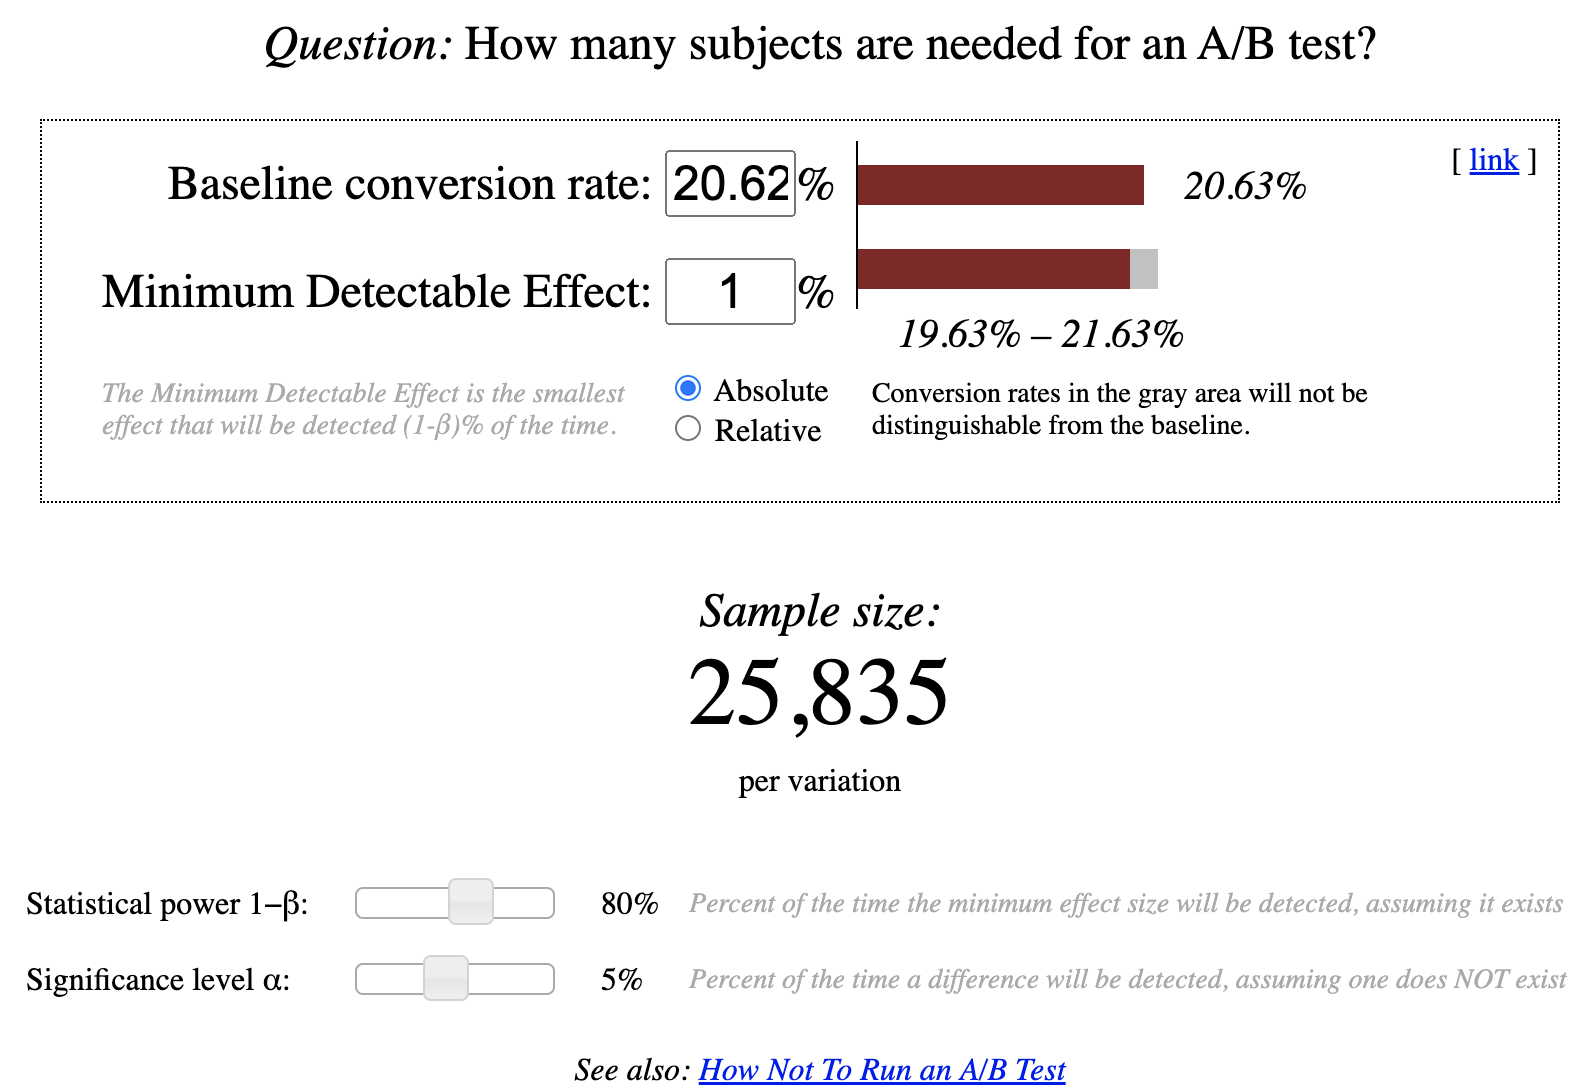
Retention
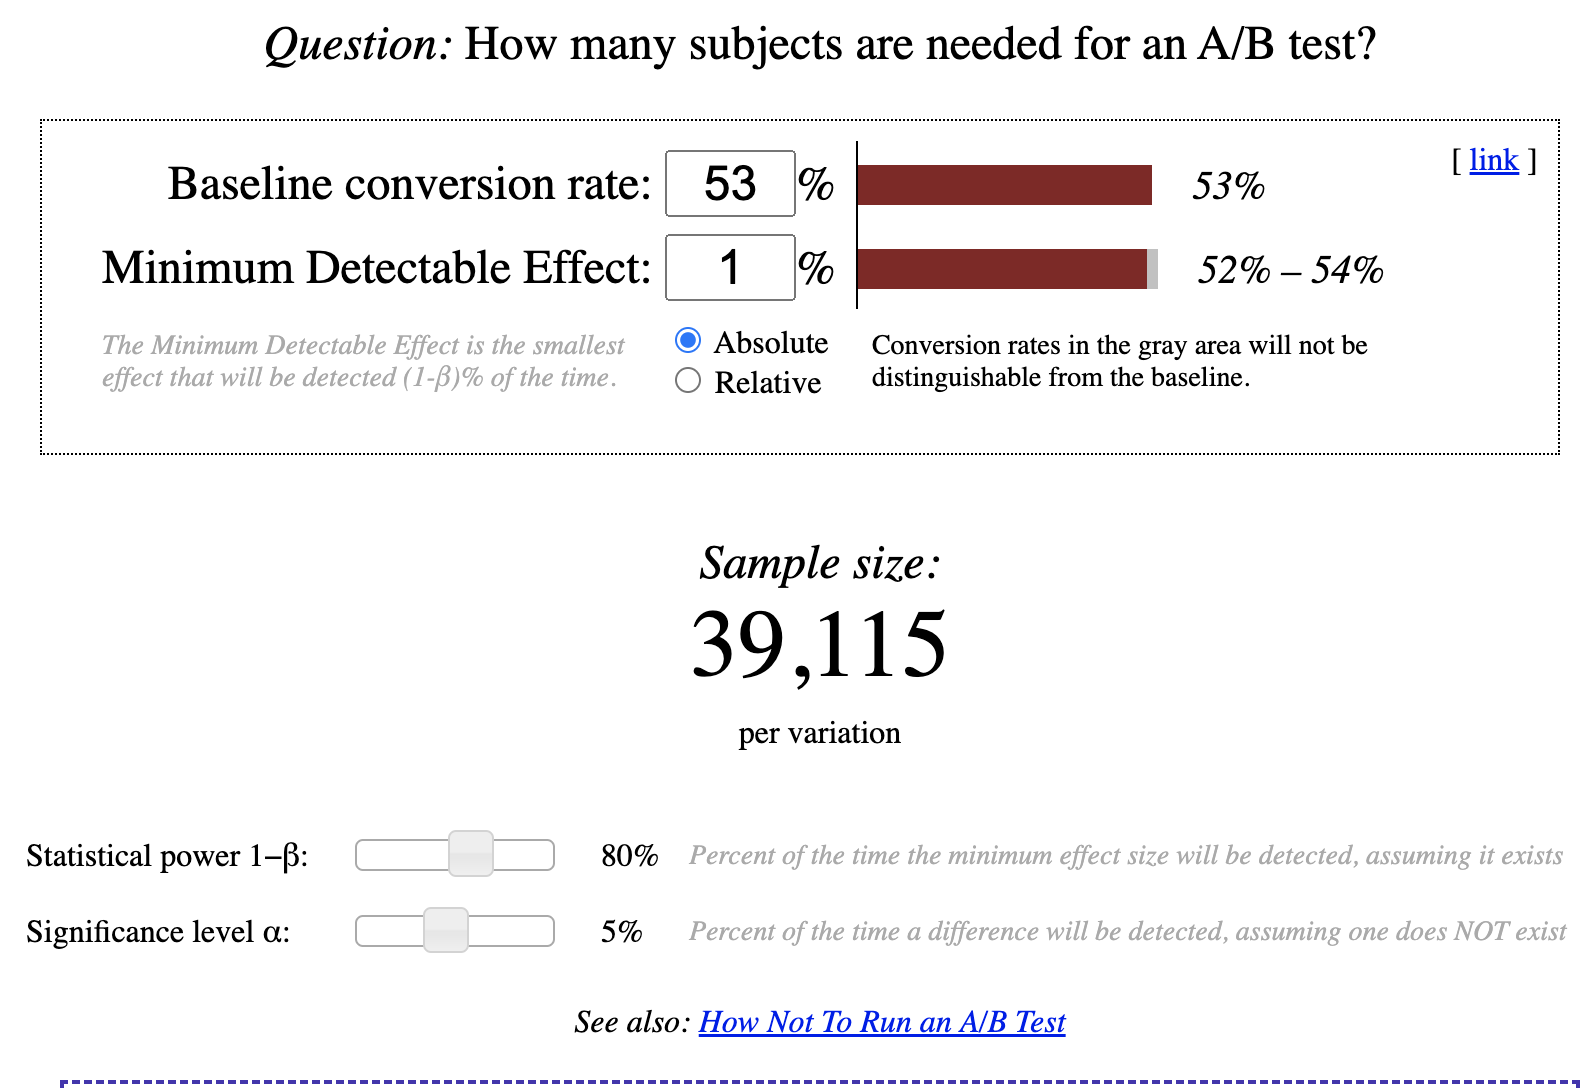
Net Conversion
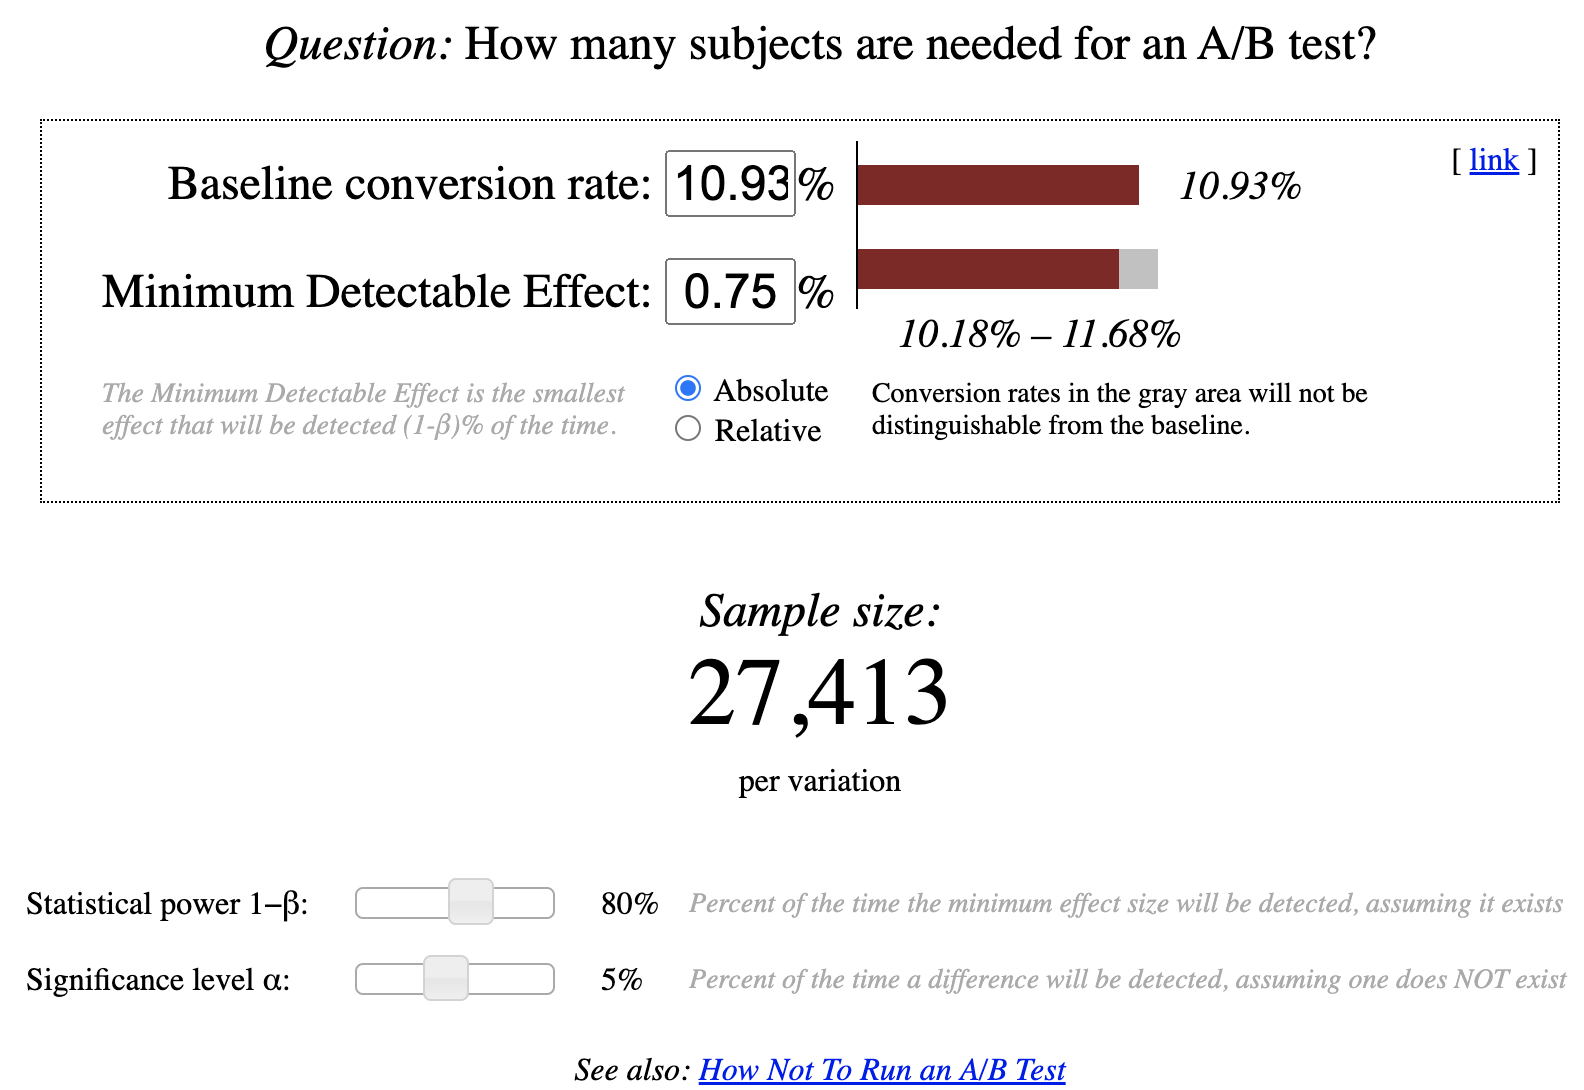

Now that we have computed the sample sizes needed for all three metrics, we need to determine the number of unique cookies required to achieve the ideal sample size for each metric:

    25,835 unique cookies that click on the "Start Free Trial" button for Gross Conversion
    39,115 user-ids to complete checkout for Retention
    27,413 unique cookies that click on the "Start Free Trial" button for Net Conversion

In [ ]:
# sample sizes 
sample_gross_conversion = 25835
sample_retention = 39115
sample_net_conversion = 27413

# given the baseline stats
click_through_rate = 0.08 # the number of cookies that click on the "Start Free Trial" button / total cookies
enroll_rate = 0.20625 # the number of cookies that enroll in the free trial / the number of cookies that click on the "Start Free Trial" button

# calculate the number cookies required for each metric. Note that we need to multiply by two to have enough samples for both treatment and control
# group (the sample size above is the sample size for treatment/control group, not the total) 

# Gross Conversion
cookies_gross_conversion = sample_gross_conversion / click_through_rate * 2 ### times 2 to get the total sample size (treatment + control)

# Retention 
cookies_retention = sample_retention / enroll_rate / click_through_rate * 2

# Net Conversion 
cookies_net_conversion = sample_net_conversion / click_through_rate * 2

# 1 unique cookie = 1 page view
print(
    f"Total page views required to have enough samples for Gross Conversion: {cookies_gross_conversion:,.0f}" +
    f"\nTotal page views required to have enough samples for Retention: {cookies_retention:,.0f}" +
    f"\nTotal page views required to have enough samples for Net Conversion: {cookies_net_conversion:,.0f}"
    f"\nTotal page views required to have enough samples for all three metrics: {(max(cookies_gross_conversion,cookies_retention,cookies_net_conversion)):,.0f}"
)


Total page views required to have enough samples for Gross Conversion: 645,875
Total page views required to have enough samples for Retention: 4,741,212
Total page views required to have enough samples for Net Conversion: 685,325
Total page views required to have enough samples for all three metrics: 4,741,212


### 3. Experiment Duration Calculation

In [65]:
# given 40,000 unique cookies/page views per day
# experiment duration = total page views required / 40, 000
views_per_day = 40000
print(
    f"Experiment duration to acquire enough samples for Gross Conversion: {cookies_gross_conversion/views_per_day:,.0f}" + " days" +
    f"\nExperiment duration to acquire enough samples for Retention: {cookies_retention/views_per_day:,.0f}" + " days" +
    f"\nExperiment duration to acquire enough samples for Net Conversion: {cookies_net_conversion/views_per_day:,.0f}" + " days"
)

Experiment duration to acquire enough samples for Gross Conversion: 16 days
Experiment duration to acquire enough samples for Retention: 119 days
Experiment duration to acquire enough samples for Net Conversion: 17 days


Above calculation suggests that we should run the experiment for 17 days, given this experiment duration can provide us enough time to collect the ideal number of samples for gross converion and retention. Measuring long-term treatment effects using rentention is crucial because the short-term results of an experiment may not capture the full impact of a treatment. User behavior or system performance might evolve over time, leading to different outcomes. We could run the experiment for 119 days or consider alternative methods such as time staggered treatment

### 4. Analysis of Experiment Result

Step 1: Sanity Check for potential SRM (Sample Ratio Mismatch)

In [66]:
import pandas as pd
from scipy import stats

control = pd.read_csv("Final Project Results - Control.csv")
treatment = pd.read_csv("Final Project Results - Experiment.csv")

control.dropna(inplace = True) # drop the rows with missing data
treatment.dropna(inplace = True)

control_total_pageviews = control["Pageviews"].sum()
treatment_total_pageviews = treatment["Pageviews"].sum()

control_total_clicks = control["Clicks"].sum()
treatment_total_clicks = treatment["Clicks"].sum()

# sample proportions for pageviews
control_pageviews_prop = control_total_pageviews / (control_total_pageviews + treatment_total_pageviews)
treatment_pageviews_prop = treatment_total_pageviews / (control_total_pageviews + treatment_total_pageviews)

# sample proportions for clicks
control_clicks_prop = control_total_clicks / (control_total_clicks + treatment_total_clicks)
treatment_clicks_prop = treatment_total_clicks / (control_total_clicks + treatment_total_clicks)

# chi-square test: why? to determine whether there is a significant difference between observed and expected frequencies in categorical data

chi2_pageviews, p_pageviews = stats.chisquare([control_total_pageviews, treatment_total_pageviews])
chi2_clicks, p_clicks = stats.chisquare([control_total_clicks, treatment_total_clicks])

print(
    f"Pageviews - Proportion of control group: {control_pageviews_prop}, Proportion of treatment group: {treatment_pageviews_prop}, P-value of Chi-squared test: {p_pageviews:}"
    f"\nClicks - Proportion of control group: {control_clicks_prop:}, Proportion of treatment group: {treatment_clicks_prop:}, P-value of Chi-squared test: {p_clicks:}"
)

# The null hypothesis of chi-squared test is that there is no significant difference between expected and observed frequencies. 
# p < 0.05 means it is very unlikely to observe such a large difference between the treatment and control groups purely by chance, assuming that there is no actual difference
# p > 0.05 suggests that it is quite likely that any observed difference between the treatment and control groups could have occurred by random chance, assuming there is no true difference.

if p_pageviews > 0.05 and p_clicks > 0.05: 
    print("Sanity check passed. No SRM detected")
else: 
    print("Sanity check failed. SRM detected")


Pageviews - Proportion of control group: 0.500945634850363, Proportion of treatment group: 0.49905436514963697, P-value of Chi-squared test: 0.21839184127571457
Clicks - Proportion of control group: 0.5004775272769368, Proportion of treatment group: 0.4995224727230631, P-value of Chi-squared test: 0.8590923254607148
Sanity check passed. No SRM detected


Step 2. Statistical Testing

 Two-tailed t-test is used because 
1. Sample Variances are Used:A t-test accommodates unknown population variances by estimating them using sample variances 

2. Small or Moderate Sample Sizes: The t-test is robust for smaller sample sizes and adjusts for degrees of freedom, making it more suitable when the number of days (or samples) is limited.

3. Unequal Variances:If you suspect that the variances between the control and treatment groups might differ, you can use Welch's t-test, which does not assume equal variances. This is implemented in Python using scipy.stats.ttest_ind with equal_var=False
4. Why two-tailed: because we would like to detect if there is any difference including decrease and increase. If we are only interested in 

Hypothesis:

H0: There is no difference for "Gross Conversion", "Retention", and " Net Conversion" in Control Group and Treatment Group 

H1: There is a difference for "Gross Conversion", "Retention", and " Net Conversion" in Control Group and Treatment Group 



In [67]:
# calculate the metrics

control["Gross Conversion"] = control["Enrollments"] / control["Clicks"]
treatment["Gross Conversion"] = treatment["Enrollments"] / treatment["Clicks"]

control["Retention"] = control["Payments"] / control["Enrollments"]
treatment["Retention"] = treatment["Payments"] / treatment["Enrollments"]

control["Net Conversion"] = control["Payments"] / control["Clicks"]
treatment["Net Conversion"] = treatment["Payments"] / treatment["Clicks"]

metrics = ["Gross Conversion", "Retention", "Net Conversion"]

# t-test for the means of two independent samples of scores
for metric in metrics:
    control_data = control[metric].dropna()
    treatment_data = treatment[metric].dropna()
    t_stat, p_value = stats.ttest_ind(control_data, treatment_data, equal_var=False)

    # degree of freedom calculation
    var1, var2 = control_data.var(), treatment_data.var() # sample variance
    n1, n2 = len(control_data), len(treatment_data) # number of days
    df = ((var1 / n1 + var2 / n2)**2) / (((var1 / n1)**2 / (n1 - 1)) + ((var2 / n2)**2 / (n2 - 1))) 

    pooled_sd = np.sqrt(var1 / n1 + var2 / n2) # combined standard error for the two groups
    margin_of_error = stats.t.ppf(0.975, df) * pooled_sd # margin of error calculated using critical t-value * standard error
    diff_means = treatment_data.mean() - control_data.mean() # difference in means

    ci_lower = diff_means - margin_of_error
    ci_upper = diff_means + margin_of_error

    print(f"{metric} - t-statistic: {t_stat}, df: {df}, p-value: {p_value}, 95% CI: [{ci_lower}, {ci_upper}]")

Gross Conversion - t-statistic: 1.5396752696188791, df: 43.75777353448117, p-value: 0.13084052551557082, 95% CI: [-0.04799494499923486, 0.006425780940702966]
Retention - t-statistic: -1.0081408912731535, df: 40.50474292438236, p-value: 0.31937163160493487, 95% CI: [-0.033475110411210984, 0.10016012534398033]
Net Conversion - t-statistic: 0.5387777625331603, df: 43.64795890688602, p-value: 0.5927776808531843, 95% CI: [-0.02321835458018533, 0.013424640600566601]


All p-values are greater than 0.05, therefore we fail to reject the null hypothesis and conclude there is no significant difference between control and treatment group. 

### 5. Recommendations and Next Steps 
Based on the statistical results, I recommend against implementing the change at this time. Informing users about the time commitment required for course success does not significantly affect their decision to start a free trial or convert to a paying user. However, this conclusion is based on a dataset that reached only 8.93% of the desired sample size—further data may yield different insights.Additionally, our guardrail metric (retention) would require over three months of experimentation to reach sufficient statistical power, whereas our test ran for only two weeks.
To ensure reliable conclusions, I recommend extending the experiment duration and increasing the sample size before making a final decision.



Minimum pageviews required: 4,741,212

Total pageviews obtained from the experiment: 423,525

In [83]:
total_clicks = control["Pageviews"].sum() + treatment["Pageviews"].sum()
print(
    f"Total pageviews in the experiment: {total_clicks:,}"
    f"\nActual sample size obtained compared to desired sample size: {(total_clicks / (max(cookies_gross_conversion,cookies_retention,cookies_net_conversion)))*100:.2f}%"
    f"\nHow many more samples do we need to reach the desired sample size: {((max(cookies_gross_conversion,cookies_retention,cookies_net_conversion)) - total_clicks):,.0f}"
)

Total pageviews in the experiment: 423,525
Actual sample size obtained compared to desired sample size: 8.93%
How many more samples do we need to reach the desired sample size: 4,317,687
